In [1]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from matplotlib import pyplot as plt
# from problema_1 import plot_bar_chart
# Importo el paquete para graficar
from matplotlib import pyplot as plt

import os
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Naive bayes - Clasificación

### Bibliografía recomendada
https://nlp.stanford.edu/IR-book/ - Capitulo 13 -  
http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

## Introducción teórica

### Teorema de Bayes
$P(y|x_1,x_2,...,x_n) = \large \frac{P(x_1, x_2,...,x_n|y) P(y)}{P(x_1,x_2,...,x_n)}$

El numerador:

$ \large P(x_1, x_2,...,x_n|y) P(y) = P(y, x_1, x_2,...,x_n)$

Por la regla de la cadena:

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2,x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

#### Ejemplo con Aplicación SPAM

$P(comprar,oferta,ganaste,SPAM) = P(comprar | oferta, ganaste,SPAM)P(oferta|ganaste, SPAM)P(ganaste| SPAM)P(SPAM)$

Asumiendo independencia

$P(x_i|y) = P(x_i|y,x_1,...)$

$P(comprar,oferta,ganaste,SPAM) = P(comprar | SPAM)P(oferta|SPAM)P(ganaste| SPAM)P(SPAM)$

### Naive Bayes

$P(y|x_1,x_2,...,x_n) = \large \frac{P(y)\prod P(x_i/y)} {P(x_1,x_2,...,x_n)} = \alpha {P(y)\prod P(x_i/y)}$

(Compararlo con teorema de Bayes)

$\large \hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

Ejemplo SPAM: 

La variable aleatoria $y$ puede ser: [SPAM, NO_SPAM]. Calculo ${P(y)\prod P(x_i/y)}$ para ambos casos y me quedo con el mayor

Como el denominador es el mismo para ambos casos, no hace falta calcularlo

## Detección de SPAM
[V. Metsis, I. Androutsopoulos and G. Paliouras (2006). Spam filtering with Naive Bayes – Which Naive Bayes? 3rd Conf. on Email and Anti-Spam (CEAS).](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=1EEA3C5EE5DDF8409BCC0F09BFB7D98B?doi=10.1.1.61.5542&rep=rep1&type=pdf)

Tenemos un dataset donde ya esta preprocesado el texto
- Lemmatization, stemming
- Stop words

In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


In [27]:
train_dir = './drive/MyDrive/Data/publica/ling-spam/train-mails'
test_dir = './drive/MyDrive/Data/publica/ling-spam/test-mails'
emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)] 

In [13]:
emails[0:10]

['./drive/MyDrive/Data/publica/ling-spam/train-mails/6-272msg1.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/spmsga86.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/spmsgb56.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/spmsgb85.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/5-1311msg1.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/spmsgb8.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/6-14msg2.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/3-380msg4.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/8-820msg1.txt',
 './drive/MyDrive/Data/publica/ling-spam/train-mails/spmsgb53.txt']

In [14]:
with open(emails[2]) as m:
    print(m)
    for i,line in enumerate(m):
        print(i, line)

<_io.TextIOWrapper name='./drive/MyDrive/Data/publica/ling-spam/train-mails/spmsgb56.txt' mode='r' encoding='UTF-8'>
0 Subject: uce : successful

1 

2 unusual project , ideas , everyone millionaire non-profit foundation seek successful = walk life = 20 extend experiment 1 ) create great personal wealth = participant 2 ) = 20 participation self study course alway whatever = want desire , = 20 without limit compromise . applicants must prior success = 20 field , field . teamwork skill willingness learn = essential . must = 20 able devote single-mind focus six month = project . must possess = 20 desire freedom personal wealth create . must = work large = 20 amount cash . short telephone interview determine = potential = 20 suitability position . project is everyone . = call 1-800 - 372-3134 x 2002 leave number ( hold strict = confidence ) = 20 day call follow-up interview . email . = 20



In [15]:
def make_Dictionary(train_dir):
    # Train dir es la carpeta para parsear
    emails_array = []
    labels = []
    # Emails es una lista con los nombres de los archivos
    emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)] 
    # All words contendrá todas las palabras del mail
    all_words = []       
    for mail in emails:
        # mail es el nombre del archivo
        with open(mail) as m:
            # m es el archivo abierto
            if 'spmsg' in mail.split('/')[-1]:
                # Si el nombre del archivo contiene 'spmsg' es spam
                labels.append(True)
            else:
                labels.append(False)
            # email_str va a guardar el mail como string
            email_str = ''
            for i,line in enumerate(m):
                if i == 2:  #Body of email is only 3rd line of text file
                    words = line.split()
                    all_words += words
                    email_str = email_str + ' ' + line
            emails_array.append(email_str)
    dictionary = Counter(all_words)
    return dictionary, emails_array, labels

def remove_uncommon_words(dictionary):
    # Dictionary es un counter
    dict_copy = { k : v for k,v in dictionary.items()}
    list_to_remove = dictionary.keys()
    for item in list_to_remove:
        if item.isalpha() == False: 
            # Remueve lo que no sean palabras con letras del abcedario
            del dict_copy[item]
        elif len(item) == 1:
            # Remueve las palabras de una letra
            del dict_copy[item]
    return Counter(dict_copy)

In [16]:
def read_emails_and_get_dict(folder, max_features=3000):
    dictionary, emails_array, labels = make_Dictionary(folder)
    dictionary = remove_uncommon_words(dictionary)
    dictionary = dictionary.most_common(max_features)
    vocabulary = [key[0] for key in dictionary]
    return vocabulary, emails_array, np.array(labels)

In [17]:
max_features = 3000

In [18]:
vocabulary, emails_array, labels = read_emails_and_get_dict(train_dir, max_features)
count_vectorizer = CountVectorizer(vocabulary=vocabulary)
feature_matrix = count_vectorizer.fit_transform(emails_array)

In [19]:
print(labels[0:10])
print(vocabulary[0:10])
print(feature_matrix)

[False  True  True  True False  True False False False  True]
['order', 'address', 'report', 'mail', 'send', 'language', 'email', 'program', 'our', 'list']
  (0, 1)	3
  (0, 3)	5
  (0, 4)	2
  (0, 5)	3
  (0, 11)	1
  (0, 16)	3
  (0, 18)	1
  (0, 20)	6
  (0, 22)	3
  (0, 27)	1
  (0, 29)	1
  (0, 31)	4
  (0, 32)	1
  (0, 33)	1
  (0, 52)	1
  (0, 62)	1
  (0, 63)	1
  (0, 72)	1
  (0, 73)	4
  (0, 77)	1
  (0, 79)	1
  (0, 82)	1
  (0, 86)	1
  (0, 90)	1
  (0, 95)	4
  :	:
  (700, 497)	1
  (700, 512)	1
  (700, 528)	1
  (700, 565)	1
  (700, 572)	1
  (700, 629)	1
  (700, 639)	1
  (700, 711)	1
  (700, 720)	1
  (700, 791)	1
  (700, 887)	1
  (700, 1365)	1
  (700, 1460)	1
  (700, 1566)	1
  (700, 1603)	1
  (700, 1755)	1
  (700, 1838)	2
  (700, 2182)	10
  (700, 2792)	1
  (701, 81)	1
  (701, 151)	1
  (701, 248)	1
  (701, 329)	1
  (701, 1150)	1
  (701, 1956)	1


In [20]:
print(feature_matrix.sum(axis=0).shape)
print(feature_matrix.sum(axis=0))
print(feature_matrix.sum(axis=0) + 1)
print((feature_matrix.sum(axis=0) + 1).sum())

(1, 3000)
[[1423 1302 1216 ...    8    8    8]]
[[1424 1303 1217 ...    9    9    9]]
157990


In [21]:
def get_histogram_from_matrix(alpha, feature_matrix):
    # Alpha es para suavizar y evitar la probabilidad cero. Normalmente 1
    # Es como agregar un mail con todas las palabras
    words_distribution_un = feature_matrix.sum(axis=0) + alpha
    words_distribution = words_distribution_un/(words_distribution_un.sum()) # + alpha*feature_matrix.shape[1])
    return words_distribution

spam_feature_matrix = feature_matrix[labels,:]
ham_feature_matrix = feature_matrix[np.logical_not(labels),:]

print('SPAM:',labels.nonzero()[0].shape[0],
      'HAM:',np.logical_not(labels).nonzero()[0].shape[0],
      'total:',len(labels))

print()
print('Palabras diferentes')
print('SPAM:', spam_feature_matrix.nonzero()[0].shape[0],
      'HAM:',ham_feature_matrix.nonzero()[0].shape[0])

print()
print('Cantidad de palabras')
print('SPAM:',spam_feature_matrix.sum(), 'HAM:',ham_feature_matrix.sum())


# P(x_i/SPAM)
spam_words_distribution = get_histogram_from_matrix(1, spam_feature_matrix)
# P(x_i/HAM)
ham_words_distribution = get_histogram_from_matrix(1, ham_feature_matrix)

SPAM: 351 HAM: 351 total: 702

Palabras diferentes
SPAM: 49331 HAM: 33310

Cantidad de palabras
SPAM: 98199 HAM: 56791


$\hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

$y = [SPAM, HAM]$

In [22]:
def plot_bar_chart(P, vocabulary = None, title='title'):
    N = len(P)
    plt.figure(figsize=(20, 5)) # Tamaño del gráfico
    indexes = list(range(1, len(P) + 1))
    plt.bar(indexes, P, width=0.75, color='b') # Grafico
    plt.title(title)

    # Definición de indices
    if not vocabulary:
        string_indexes = [str(i) for i in indexes]
    else:
        string_indexes = [vocabulary[i-1] for i in indexes]
    plt.xlim([0,N+1])
    plt.xticks(indexes, string_indexes) 
    plt.xticks(rotation=60)
    plt.show()

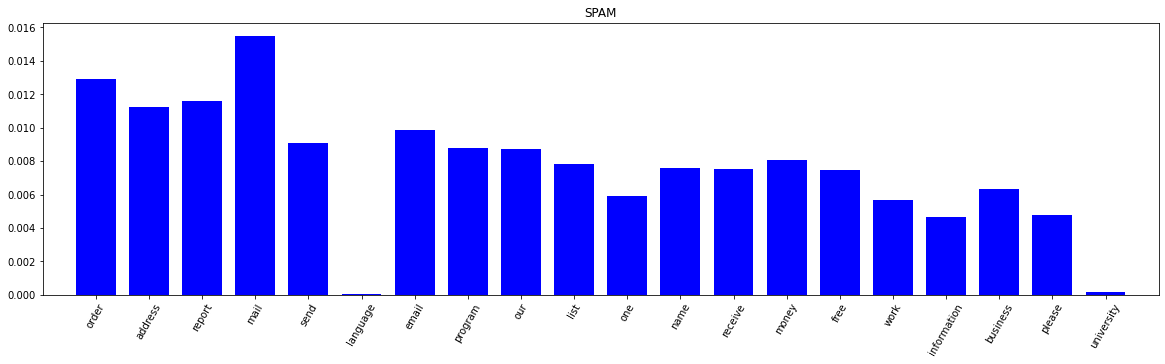

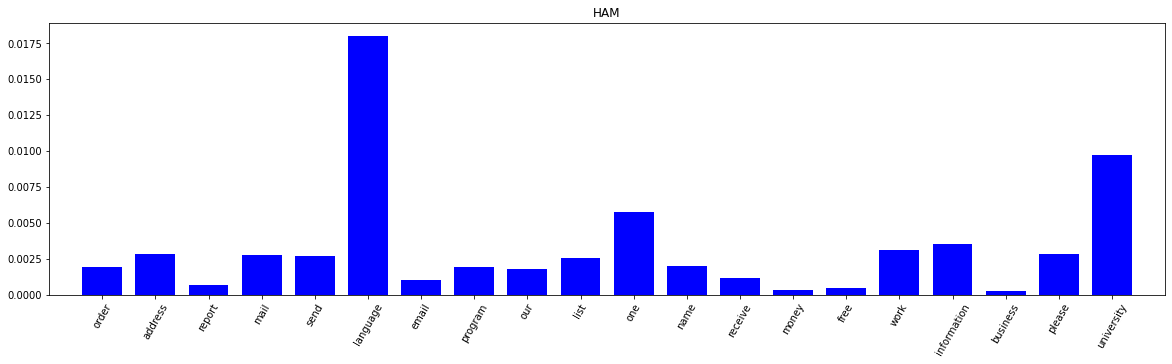

In [23]:
N = 20
plot_bar_chart(np.array(spam_words_distribution)[0][:N],
               vocabulary = vocabulary,
               title='SPAM')
plot_bar_chart(np.array(ham_words_distribution)[0][:N],
               vocabulary = vocabulary,
               title='HAM')

In [24]:
# Veamos si el primer email es SPAM o no
# El primer mail corresponde a la primer fila de la matriz
row = feature_matrix[0,:]
print('Primer email codificado:')
print(row)
non_zero_row = row.nonzero()
print('Elementos distintos de cero:',non_zero_row[1])
print('Producto, no es necesario [P(Y) = P(SPAM) = P(HAM)] por que es para ambos casos igual. Lo mismo el denominador')
print(np.power(spam_words_distribution[non_zero_row], feature_matrix[non_zero_row]).prod())
print(np.power(ham_words_distribution[non_zero_row], feature_matrix[non_zero_row]).prod())
print('Log likelihood')
print(np.log(spam_words_distribution[non_zero_row])*feature_matrix[non_zero_row].T)
print(np.log(ham_words_distribution[non_zero_row])*feature_matrix[non_zero_row].T)

Primer email codificado:
  (0, 1)	3
  (0, 3)	5
  (0, 4)	2
  (0, 5)	3
  (0, 11)	1
  (0, 16)	3
  (0, 18)	1
  (0, 20)	6
  (0, 22)	3
  (0, 27)	1
  (0, 29)	1
  (0, 31)	4
  (0, 32)	1
  (0, 33)	1
  (0, 52)	1
  (0, 62)	1
  (0, 63)	1
  (0, 72)	1
  (0, 73)	4
  (0, 77)	1
  (0, 79)	1
  (0, 82)	1
  (0, 86)	1
  (0, 90)	1
  (0, 95)	4
  :	:
  (0, 1153)	1
  (0, 1212)	7
  (0, 1257)	1
  (0, 1285)	1
  (0, 1286)	1
  (0, 1418)	1
  (0, 1419)	1
  (0, 1480)	3
  (0, 1481)	1
  (0, 1482)	2
  (0, 1531)	1
  (0, 1532)	1
  (0, 1568)	1
  (0, 1594)	1
  (0, 1650)	2
  (0, 1971)	2
  (0, 2081)	3
  (0, 2209)	1
  (0, 2210)	3
  (0, 2493)	1
  (0, 2661)	1
  (0, 2662)	1
  (0, 2858)	2
  (0, 2859)	1
  (0, 2860)	1
Elementos distintos de cero: [   1    3    4    5   11   16   18   20   22   27   29   31   32   33
   52   62   63   72   73   77   79   82   86   90   95   99  109  110
  111  118  126  138  158  164  173  195  203  214  233  250  251  263
  269  293  303  310  313  337  340  341  345  375  397  402  410  438
  439  470

¿Por que usamos log likelihood?

In [25]:
def get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution):
    P_SPAM = labels.nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    P_HAM = np.logical_not(labels).nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    correct_count = 0
    for i, row in enumerate(feature_matrix):
        coded_email = row.nonzero()
        spam_prod = np.log(spam_words_distribution[coded_email]) * feature_matrix[i][coded_email].T
        ham_prod = np.log(ham_words_distribution[coded_email]) * feature_matrix[i][coded_email].T
        spam_log_likelihood = spam_prod+ np.log(P_SPAM)
        ham_log_likelihood = ham_prod + np.log(P_HAM)
        SPAM = spam_log_likelihood>=ham_log_likelihood
        if SPAM == labels[i]:
            correct_count = correct_count + 1
    print('%0.3f'%(correct_count/len(labels)))

In [26]:
get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution)

0.990


## Test set

In [28]:
_, emails_array, labels_test = read_emails_and_get_dict(test_dir, max_features)
count_vectorizer_test = CountVectorizer(vocabulary=vocabulary)
feature_matrix_test = count_vectorizer.fit_transform(emails_array)

In [29]:
get_accuracy(feature_matrix_test, labels_test, spam_words_distribution, ham_words_distribution)

0.962


# Sklearn MultinomialNB

In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
clf = MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)

In [32]:
clf.fit(feature_matrix, labels)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False)

In [33]:
clf.score(feature_matrix, labels)

0.99002849002849

In [34]:
clf.score(feature_matrix_test, labels_test)

0.9615384615384616

In [35]:
clf.predict(feature_matrix_test[100:150])

array([ True,  True, False, False, False, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True, False,
       False, False,  True, False,  True, False,  True,  True, False,
       False,  True, False,  True, False, False,  True, False, False,
       False,  True,  True, False, False,  True,  True, False, False,
        True, False, False, False, False])

In [36]:
clf.predict_proba(feature_matrix_test[100:110])

array([[3.29582050e-014, 1.00000000e+000],
       [4.02584040e-002, 9.59741596e-001],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 2.14876180e-030],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 1.69993176e-106],
       [9.10144641e-018, 1.00000000e+000],
       [3.31173125e-036, 1.00000000e+000],
       [2.35184092e-020, 1.00000000e+000],
       [1.00000000e+000, 3.51081126e-051]])

# Sklearn BernoulliNB
Suele ser interesante evaluar Multinomial y Bernoulli para comparar resultados. A veces para textos cortos BernoulliNB puede dar mejores resultados

In [37]:
from sklearn.naive_bayes import BernoulliNB

In [38]:
clf_Ber = BernoulliNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=False, binarize=0.5)

In [39]:
clf_Ber.fit(feature_matrix, labels)

BernoulliNB(alpha=1, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

In [40]:
clf_Ber.score(feature_matrix, labels)

0.8589743589743589

In [41]:
clf_Ber.score(feature_matrix_test, labels_test)

0.7653846153846153

# ¿Es posible graficar un problema de dimensión 3000 en 2 dimensiones?

In [42]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
fmd = feature_matrix.todense()
svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(fmd.T)
X_embedded = TSNE(n_components=2).fit_transform(svd.components_.T)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


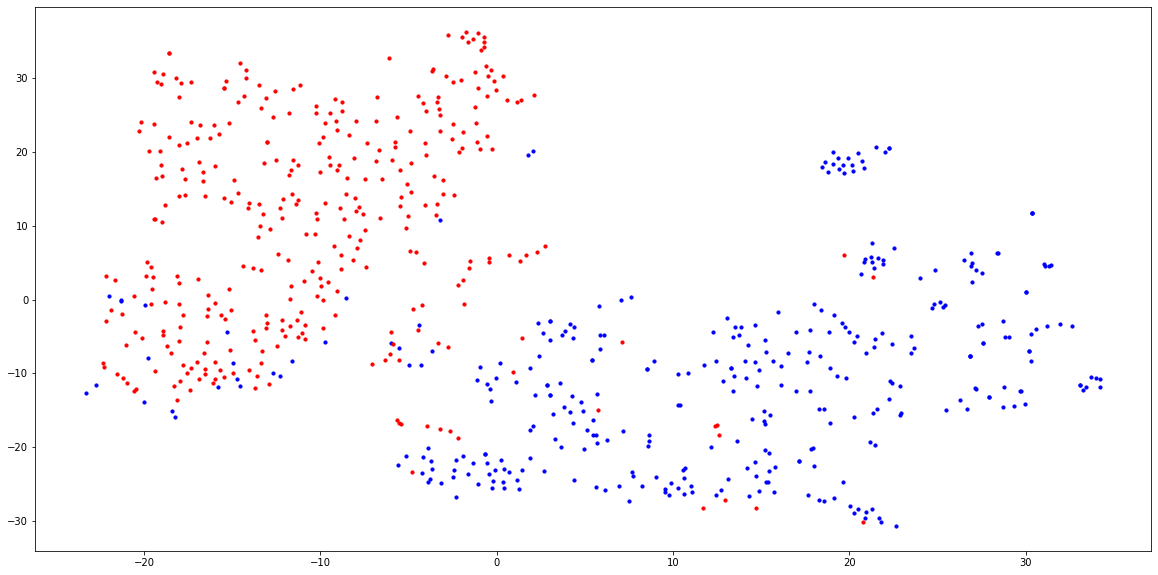

In [43]:
plt.figure(figsize=(20,10))
plt.scatter(X_embedded[labels,0], X_embedded[labels,1], color='b', s=10)
plt.scatter(X_embedded[np.logical_not(labels),0], X_embedded[np.logical_not(labels),1], color='r', s=10)
plt.show()

In [44]:
fmd.shape

(702, 3000)

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(fmd)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


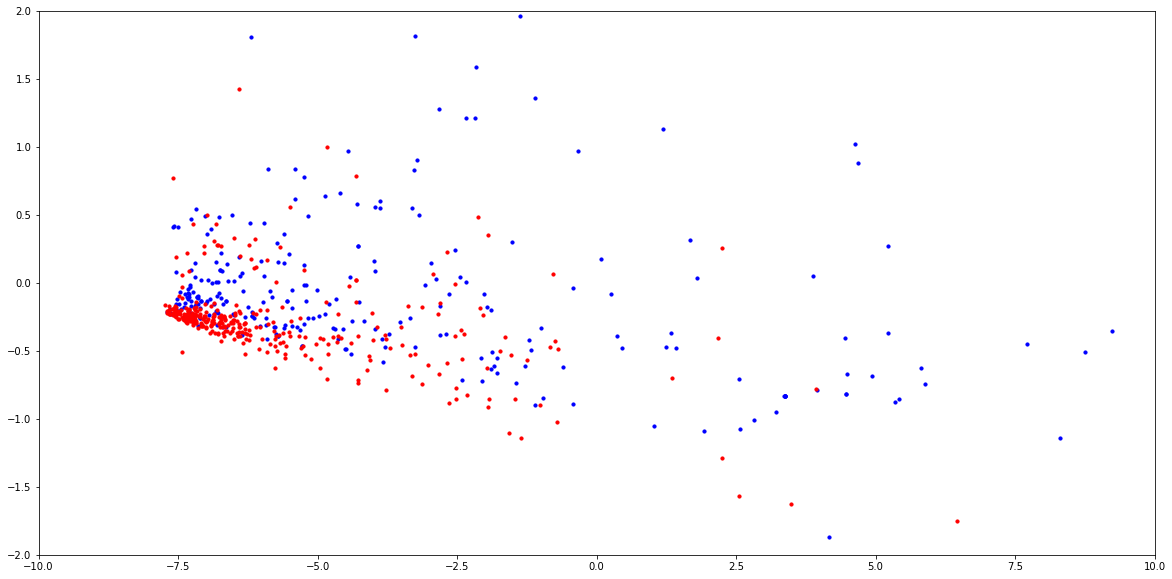

In [47]:
plt.figure(figsize=(20,10))
plt.scatter(X_new[labels,0], X_new[labels,1], color='b', s=10)
plt.scatter(X_new[np.logical_not(labels),0], X_new[np.logical_not(labels),1], color='r', s=10)
plt.ylim([-2,2])
plt.xlim([-10,10])
plt.show()